In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
import os
os.chdir('/content/drive/MyDrive/')

## Data preparing

In [85]:
data = pd.read_csv('final_data.csv')

In [86]:
data.drop('Unnamed: 0' ,axis=1, inplace=True)

In [87]:
data.head()

,Year,Month,Day,Hour,Air pressure,Air temperature,RAD radiation,Precipitation,Realtive humidity,UVB radiation,CO,NO2,NOx,O3,PM2.5,PM10,SO2,C6H6
0,2015,1,1,0,1012.0,-6.6,0.0,62.8,1.6,278.0,0.575,18.0,20.0,7.0,19.0,NaN,35.778146,5.01000
1,2015,1,1,1,1011.0,-7.4,0.0,69.6,1.5,279.0,0.581,20.0,25.0,7.0,13.0,50.0,244.272000,5.25388
2,2015,1,1,2,1011.0,-7.1,0.0,72.3,1.4,286.0,0.678,20.0,25.0,6.0,11.0,34.0,102.633000,4.74133
3,2015,1,1,3,1012.0,-6.5,0.2,71.0,1.5,292.0,0.686,21.0,24.0,6.0,9.0,29.0,77.725900,4.66580
4,2015,1,1,4,1012.0,-5.6,0.0,69.2,1.7,299.0,0.653,22.0,25.0,6.0,10.0,21.0,69.562100,4.77038


In [88]:
def prepare_data(data):
  #Preparing dataset for model
  data2015 = data[data.Year==2015]
  data_2015_by_day = data2015.groupby(['Month','Day']).mean()
  data_2015_by_day.reset_index(drop=True, inplace=True)
  data_2015_by_day.reset_index(drop=True, inplace=True)
  data_2015_by_day = data_2015_by_day['NOx']
  data2016 = data[data.Year==2016]
  data_2016_by_day = data2016.groupby(['Month','Day']).mean()
  data_2016_by_day.reset_index(drop=True, inplace=True)
  data_2016_by_day.reset_index(drop=True, inplace=True)
  data_2016_by_day = data_2016_by_day['NOx']
  data2017 = data[data.Year==2017]
  data_2017_by_day = data2017.groupby(['Month','Day']).mean()
  data_2017_by_day.reset_index(drop=True, inplace=True)
  data_2017_by_day.reset_index(drop=True, inplace=True)
  data_2017_by_day = data_2017_by_day['NOx']
  combine = [data_2015_by_day,data_2016_by_day,data_2017_by_day]
  data = pd.concat(combine)
  return data

In [89]:
data = prepare_data(data)

In [90]:
NOx_by_day  = data[0:1093]

In [91]:
NOx_by_day = NOx_by_day.reset_index(drop=True)

In [92]:
NOx_timestamp = np.arange(1,data.shape[0]+1)
NOx_by_day = data

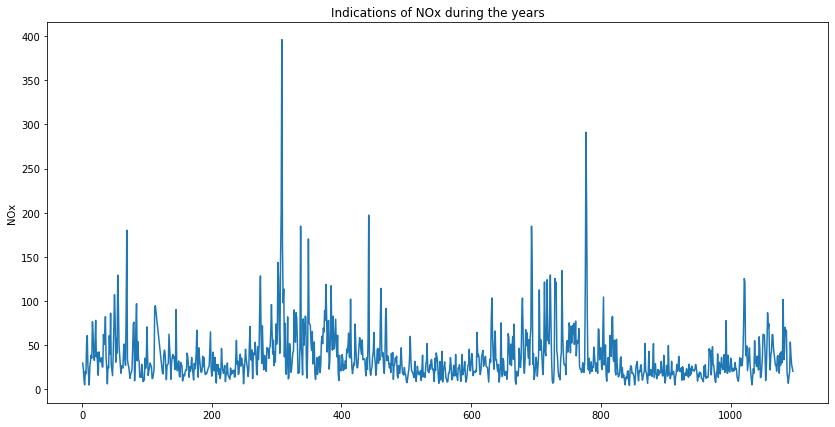

In [135]:
plt.figure(figsize=(14,7))
sns.lineplot(NOx_timestamp, NOx_by_day)
plt.title('Indications of NOx during the years')
plt.show()

In [94]:
train, test = NOx_by_day[0:728], NOx_by_day[728:1092]

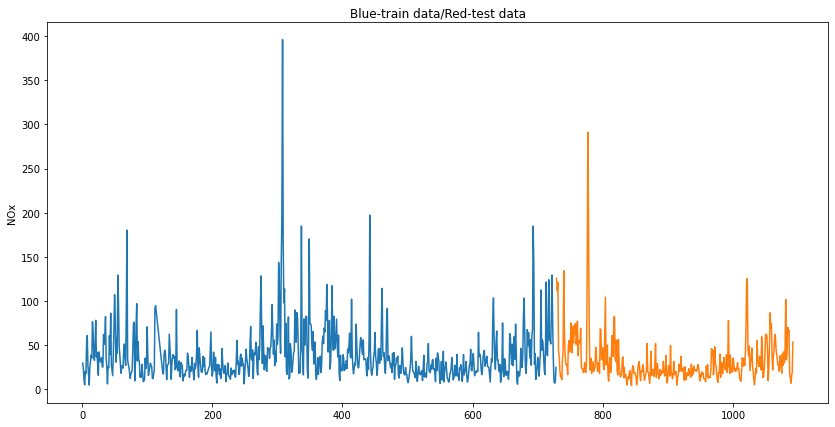

In [136]:
plt.figure(figsize=(14, 7))
sns.lineplot(NOx_timestamp[0:728], train)
sns.lineplot(NOx_timestamp[728:1092], test)
plt.title('Blue-train data/Red-test data')
plt.show()

## Basic tests and informations about signal

### Autocorellation plot to chose lag by day

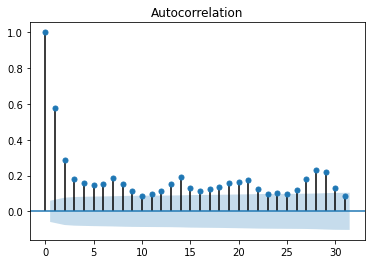

In [96]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
plot_acf(data)
pyplot.show()

**Commentary**: 
From the graph it can be concluded that the best for forecasting will be the next day and second day. For further forecast there is also visible that 21 days has got quite large correlation. Due to the ease of modeling 7 days will be also optimal range.

### Dickey-Fuller test 

*   H0: Time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

* HA: Time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [97]:
#DICKEY FULLER TEST BY DAY
#Check if the data can be represented by a unit root, which means that data is not stationary. 
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
dickey_data = data.values
result = adfuller(dickey_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.383070
p-value: 0.000004
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


**Commentary**: 
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


## Naive forecasting

In [98]:
naive_forecast = NOx_by_day[728 - 1:1091]
validation = NOx_by_day[728:1092]

Text(0.5, 1.0, 'Naive annual forecasts for NOx')

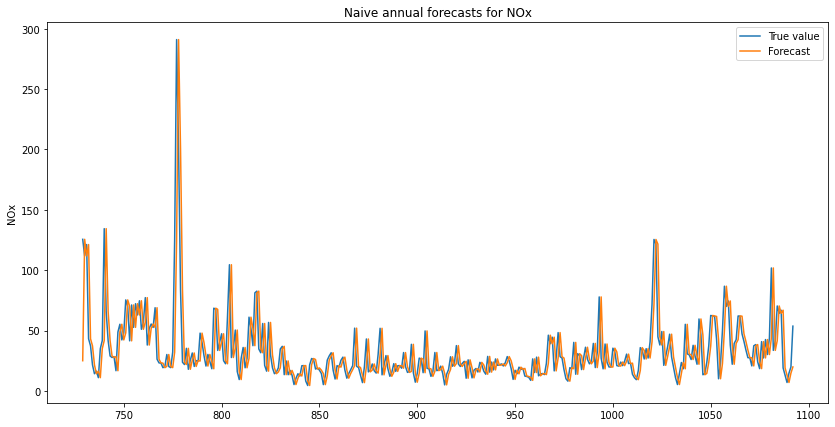

In [137]:
plt.figure(figsize=(14, 7))
ax1 = sns.lineplot(NOx_timestamp[728:1092], validation, label='True value')
ax2 = sns.lineplot(NOx_timestamp[728:1092], naive_forecast, label='Forecast')
plt.title('Naive annual forecasts for NOx')

In [100]:
print('Annual RMSE: {}'.format(np.sqrt(mean_squared_error(validation, naive_forecast))))
print('Annual MSE: {}'.format(mean_absolute_error(validation, naive_forecast)))

Annual RMSE: 23.33550267356388
Annual MSE: 14.205294067765568


## Moving average

In [101]:
NOx_by_day = data

In [102]:
validation_time = NOx_timestamp[728:1092]

In [103]:
series = NOx_by_day[721:1092]

In [104]:
def moving_average_forecast(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [105]:
moving_avg = moving_average_forecast(series, 7)

Text(0.5, 1.0, 'Moving average NOx forecasts')

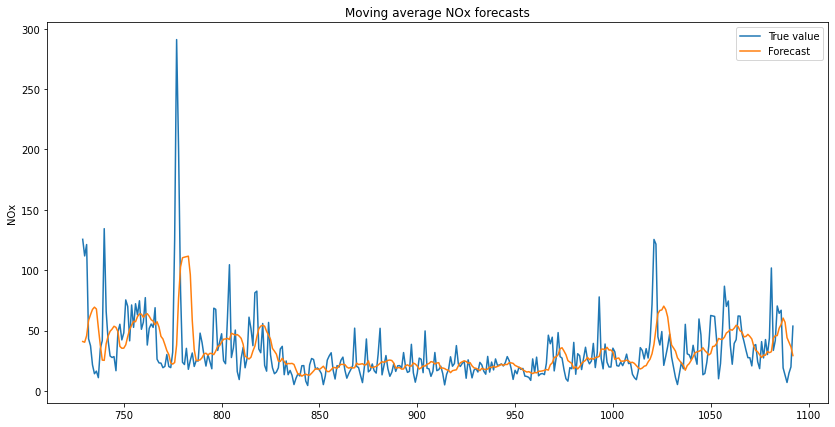

In [138]:
plt.figure(figsize=(14, 7))
ax1 = sns.lineplot(validation_time, series[7:], label='True value')
ax2 = sns.lineplot(validation_time, moving_avg, label='Forecast')
plt.title('Moving average NOx forecasts')

In [112]:
print('Annual RMSE: {}'.format(np.sqrt(mean_squared_error(series[7:], moving_avg))))
print('Annual MSE: {}'.format(mean_absolute_error(series[7:], moving_avg)))

Annual RMSE: 27.075237561495793
Annual MSE: 15.561473616071428


## Dataset differencing

In [113]:
data = data[0:1093]

In [114]:
series = NOx_by_day[721:1092]

In [115]:
def difference(dataset, interval=1):
  #Creating a differenced series
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [116]:
data_diff = difference(data.values)

In [117]:
NOx_timestamp_diff = np.arange(1,data_diff.shape[0]+1)
NOx_by_day_diff = data_diff

In [118]:
validation_time = NOx_timestamp_diff[728:1092]
series_diff = NOx_by_day_diff[721:1092]

Text(0.5, 1.0, 'Differenced NOx with shift of 1')

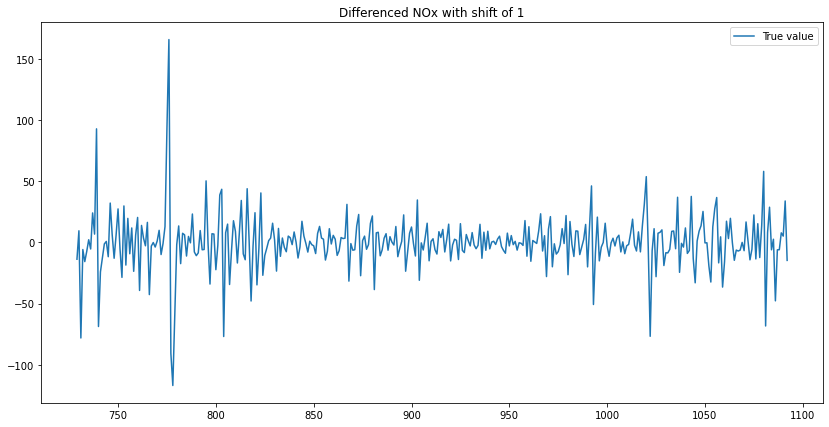

In [139]:
plt.figure(figsize=(14, 7))
ax1 = sns.lineplot(NOx_timestamp_diff[728:1092], series_diff[7:], label='True value')
plt.title('Differenced NOx with shift of 1')

In [120]:
diff_moving_avg = moving_average_forecast(series_diff, 7)

Text(0.5, 1.0, 'Differenced NOx moving average forecasts')

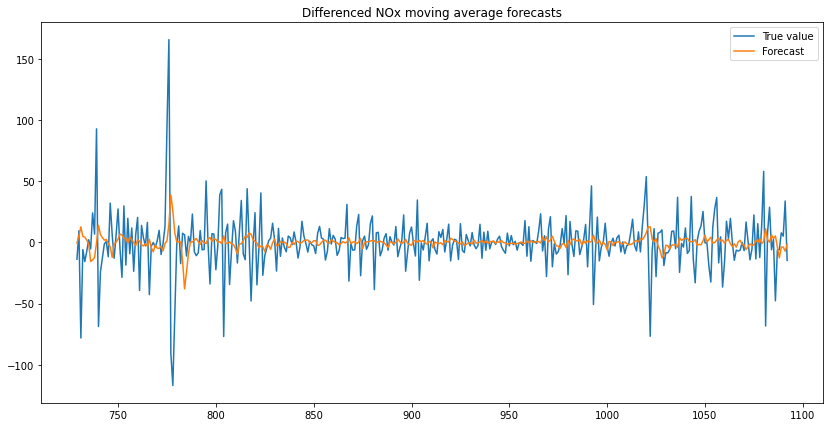

In [140]:
plt.figure(figsize=(14, 7))
ax1 = sns.lineplot(validation_time, series_diff[7:], label='True value')
ax2 = sns.lineplot(validation_time, diff_moving_avg, label='Forecast')
plt.title('Differenced NOx moving average forecasts')

In [122]:
print('Annual RMSE: {}'.format(np.sqrt(mean_squared_error(series_diff[7:], diff_moving_avg))))
print('Annual MSE: {}'.format(mean_absolute_error(series_diff[7:], diff_moving_avg)))

Annual RMSE: 24.69884377170082
Annual MSE: 15.289756637264523


## Undo difference data

Text(0.5, 1.0, 'NOx data in original scale')

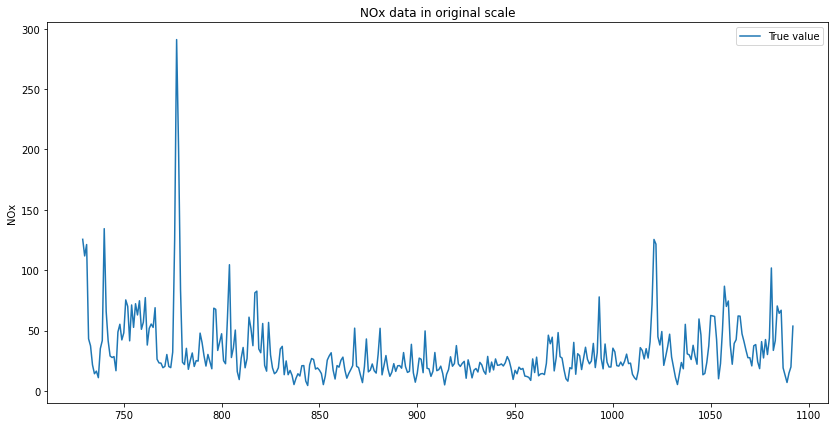

In [141]:
plt.figure(figsize=(14, 7))
sns.lineplot(NOx_timestamp[728:1092], NOx_by_day[728:1092], label='True value')
plt.title('NOx data in original scale')

Text(0.5, 1.0, 'NOx data in differenced scale')

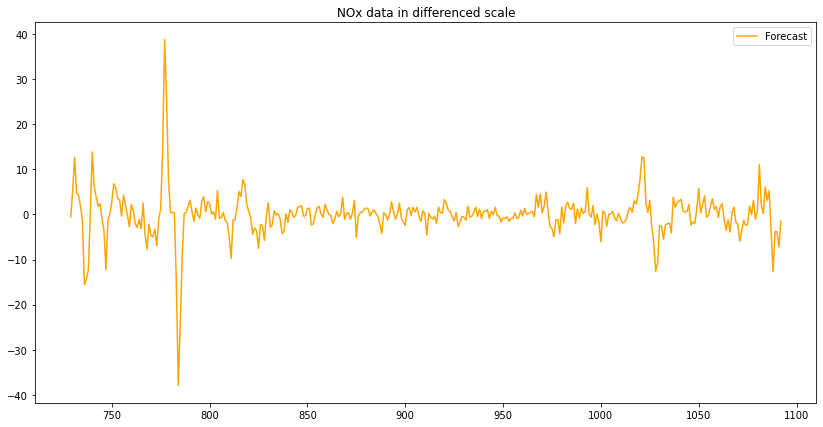

In [142]:
plt.figure(figsize=(14, 7))
sns.lineplot(validation_time, diff_moving_avg, color='orange', label='Forecast')
plt.title('NOx data in differenced scale')

In [143]:
diff_forecast = NOx_by_day[727:1091] + diff_moving_avg

Text(0.5, 1.0, 'NOx forecast using differenced dataset and moving average forecasting')

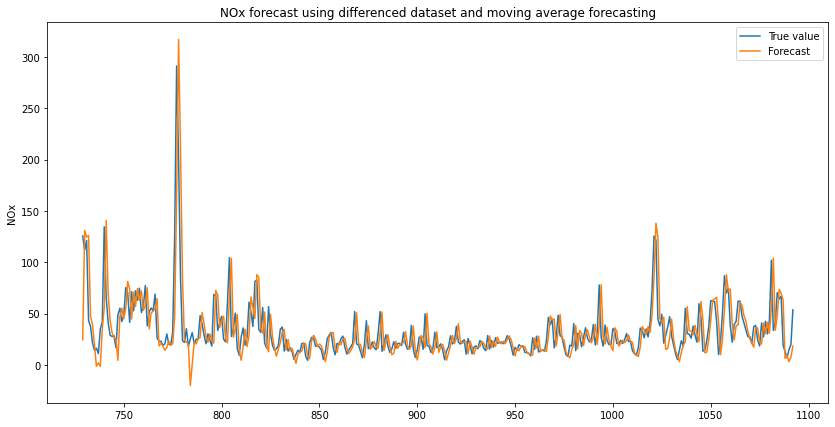

In [144]:
plt.figure(figsize=(14, 7))

ax1 = sns.lineplot(NOx_timestamp[728:1092], NOx_by_day[728:1092], label='True value')
ax2 = sns.lineplot(validation_time, diff_forecast, label='Forecast')
plt.title('NOx forecast using differenced dataset and moving average forecasting')

In [145]:
print('Annual RMSE: {}'.format(np.sqrt(mean_squared_error(NOx_by_day[728:1092], diff_forecast))))
print('Annual MSE: {}'.format(mean_absolute_error(NOx_by_day[728:1092], diff_forecast)))

Annual RMSE: 22.741321426275974
Annual MSE: 14.093082803211669


## Smooth past values using moving average

In [146]:
smooth = moving_average_forecast(NOx_by_day[721:1092],7)

In [147]:
diff_forecast_smooth = smooth + diff_moving_avg

Text(0.5, 1.0, 'NOx forecast using differenced dataset and moving average forecasting')

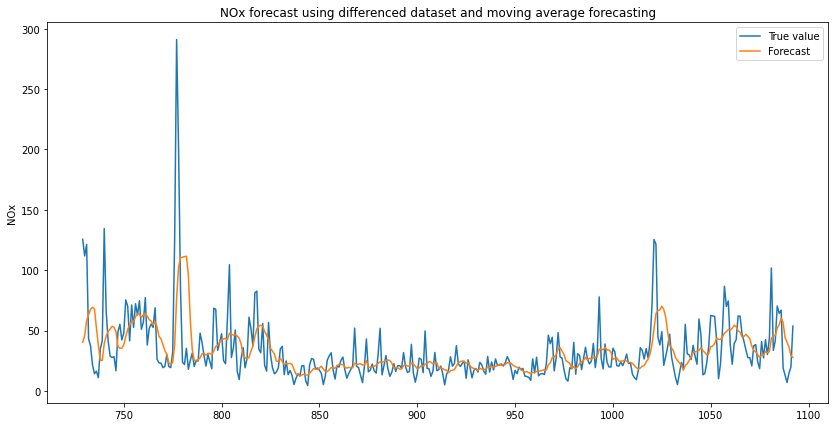

In [148]:
plt.figure(figsize=(14, 7))

ax1 = sns.lineplot(NOx_timestamp[728:1092], NOx_by_day[728:1092], label='True value')
ax2 = sns.lineplot(validation_time, diff_forecast_smooth, label='Forecast')
plt.title('NOx forecast using differenced dataset and moving average forecasting')

In [149]:
print('Annual RMSE: {}'.format(np.sqrt(mean_squared_error(NOx_by_day[728:1092], diff_forecast_smooth))))
print('Annual MSE: {}'.format(mean_absolute_error(NOx_by_day[728:1092], diff_forecast_smooth)))

Annual RMSE: 23.710011359696356
Annual MSE: 13.789111568714024
